In [1]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as pl
from scipy.spatial.distance import cdist
from numpy.linalg import inv
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel
import astropy
from astropy.io import fits

Formerly was following Suzanne Aigrain's LSST tutorial on GPs: https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session4/Day2/GPLecture1.ipynb

Since then have been following Dan Foreman-Mackey's george tutorial: https://george.readthedocs.io/en/latest/tutorials/first/

# 1) Inspect the data

Downloaded directly from https://archive.stsci.edu/k2/preview.php?dsn=ktwo246301900-c12&type=lc

In [2]:
import pandas as pd

ts = pd.read_csv('/Users/chris/Desktop/superflares/c12/246300000/01900/ts.txt', sep=", ", header=0)
ts.columns = ["BJD - 2454833", "Corrected Flux"] 
print(ts.head())
print(ts.tail())

   BJD - 2454833  Corrected Flux
0    2905.581553        0.984912
1    2905.601985        0.985306
2    2905.622418        0.985967
3    2905.642850        0.985878
4    2905.663282        0.986161
      BJD - 2454833  Corrected Flux
3348    2984.161921        1.039136
3349    2984.182353        1.038834
3350    2984.202784        1.044875
3351    2984.223216        1.042245
3352    2984.243648        1.041783


/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


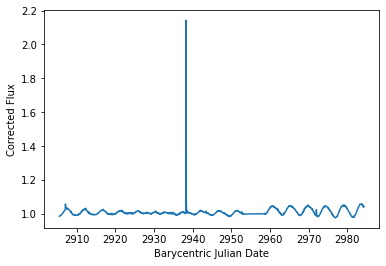

In [3]:
pl.plot(ts["BJD - 2454833"], ts["Corrected Flux"])
pl.xlabel("Barycentric Julian Date")
pl.ylabel("Corrected Flux")
pl.show()
#pl.savefig("fig1.pdf")

There are index gaps in this data format, so let's go to the more "raw" fits files from the same source.

In [4]:
filename = '/Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [5]:
hdu = hdul[1]
#hdu.header

In [6]:
data = fits.getdata(filename,header=True,ext=1)
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(df.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

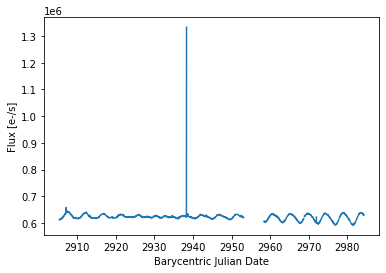

In [7]:
pl.plot(df.TIME, df.PDCSAP_FLUX)
pl.xlabel("Barycentric Julian Date")
pl.ylabel("Flux [e-/s]")
pl.show()

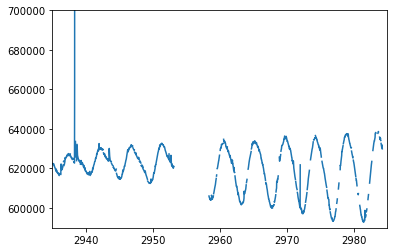

In [8]:
# examine the gap
pl.plot(df.TIME, df.PDCSAP_FLUX)
pl.xlim([2935,2985])
pl.ylim([590000,700000])
pl.show()

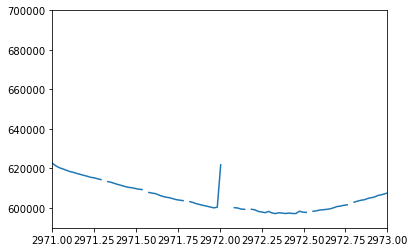

3256    601289.4375
3257    600915.5625
3258    600486.1250
3259    600089.1250
3260    600415.0000
3261    621832.1875
3262            NaN
3263            NaN
3264            NaN
3265    600196.0000
Name: PDCSAP_FLUX, dtype: float32


In [9]:
# examine spike/possible flare shortly after 2970 BJD
pl.plot(df.TIME, df.PDCSAP_FLUX)
pl.xlim([2971,2973])
pl.ylim([590000,700000])
pl.show()

print(df.loc[(df.TIME>2971.9) & (df.TIME<2972.1)].PDCSAP_FLUX)
# ...classic, NaNs right where I need data

# 2) GP Modeling

3255


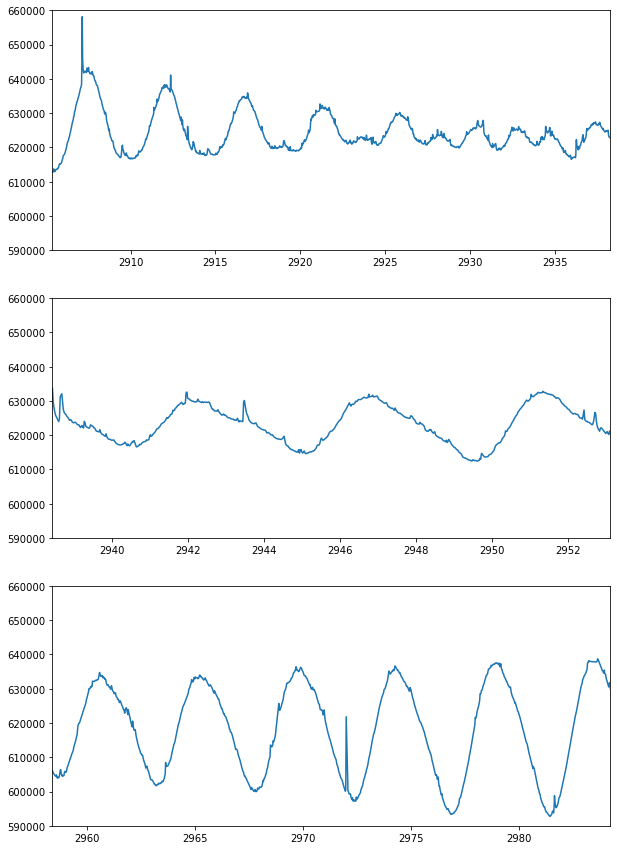

In [10]:
# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder())
df = df.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(df))

pre = df.loc[:1611] # next record is the beginning of the flare, so stop here
post = df.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = df.loc[2337:] # start from end of the gap in data until end of time series data

pl.figure(figsize=(10,15))
pl.subplot(311)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
pl.xlim(min(pre.TIME),max(pre.TIME))
pl.ylim(590000,660000)
pl.plot(xobs,yobs)

pl.subplot(312)
xobs = np.array(post["TIME"])
yobs = np.array(post["PDCSAP_FLUX"])
pl.xlim(min(post.TIME),max(post.TIME))
pl.ylim(590000,660000)
pl.plot(xobs,yobs)

pl.subplot(313)
xobs = np.array(postgap["TIME"])
yobs = np.array(postgap["PDCSAP_FLUX"])
pl.xlim(min(postgap.TIME),max(postgap.TIME))
pl.ylim(590000,660000)
pl.plot(xobs,yobs)
pl.show()

I try two different kernels and find that maximizing likelihood overfits. In deciding on my priors, though, I find good-but-not-too-good parameters such that I can smoothly model the quiescent rotation of the star.

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[22.35342  22.366695 22.37839  ... 22.937845 22.940638 22.949953]
[3.6470654e-05 3.6493650e-05 3.6516780e-05 ... 3.6823647e-05 3.6834077e-05
 3.6852922e-05]


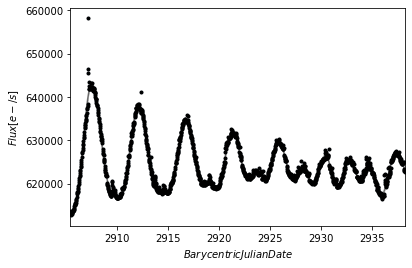

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[612530.40494126 612690.92262119 612838.72269607 ... 623058.49041241
 622867.90903815 622669.84993535]


In [44]:
lhs = min(pre.TIME)
rhs = max(pre.TIME)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
eobs = np.array(pre["PDCSAP_FLUX_ERR"])
print(yobs)
print(eobs)
print(np.abs(eobs/yobs))

gamma = 50
logperiod = np.log(50)
kernel = np.var(yobs) * ExpSine2Kernel(gamma, logperiod) # kernel number one
gp = george.GP(kernel)
gp.compute(xobs, eobs)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(yobs, xobs, return_var=True)

pl.fill_between(xobs, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(xobs, yobs, yerr=eobs, fmt=".k", capsize=0)
pl.xlim(lhs, rhs)
#pl.xlim(lhs,2910)
#pl.ylim(600000,650000)
pl.xlabel(r'$Barycentric Julian Date$')
pl.ylabel(r'$Flux [e-/s]$')
pl.scatter(xobs, yobs, s=5)
pl.show()

print(yobs)
print(pred)

Looks good!

In [45]:
kernel

ConstantKernel(log_constant=17.361727572324508, ndim=1, axes=array([0])) * ExpSine2Kernel(gamma=50.0, log_period=3.912023005428146, ndim=1, axes=array([0]))

In [46]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(yobs)))


Initial ln-likelihood: -886238.48


In [47]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(yobs)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(yobs)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(yobs)))

      fun: 24775.0600761898
 hess_inv: array([[1.93667605e-06, 1.00918585e-02, 6.32166049e-10],
       [1.00918585e-02, 5.59135333e+01, 6.23662763e-06],
       [6.32166049e-10, 6.23662763e-06, 3.86488254e-11]])
      jac: array([-2.78550316e+01, -8.15429688e-02,  6.35200000e+03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 202
      nit: 22
     njev: 185
   status: 2
  success: False
        x: array([3.97642729e+01, 1.72945506e+04, 3.49612505e+00])

Final ln-likelihood: -24775.06


In [48]:
kernel

ConstantKernel(log_constant=39.76427289856903, ndim=1, axes=array([0])) * ExpSine2Kernel(gamma=17294.550585304434, log_period=3.4961250499410323, ndim=1, axes=array([0]))

[612915.24938965 612892.81323242 612824.81103516 ... 622910.7512207
 622810.18688965 622744.43798828]


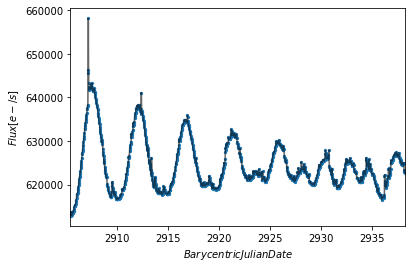

In [49]:
pred, pred_var = gp.predict(yobs, xobs, return_var=True)
print(pred)
pl.fill_between(xobs, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
#pl.errorbar(xobs, yobs, yerr=yobs, fmt=".k", capsize=0)
pl.xlim(lhs, rhs)
#pl.xlim(lhs,2910)
#pl.ylim(600000,650000)
pl.xlabel(r'$Barycentric Julian Date$')
pl.ylabel(r'$Flux [e-/s]$')
pl.scatter(xobs, yobs, s=5)
pl.show()

I'm overfitting. Let's just use non-maximized-likelihood GP model, but before we do that, let's see if we can do the same with a different kernel.

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[22.35342  22.366695 22.37839  ... 22.937845 22.940638 22.949953]
[3.6470654e-05 3.6493650e-05 3.6516780e-05 ... 3.6823647e-05 3.6834077e-05
 3.6852922e-05]


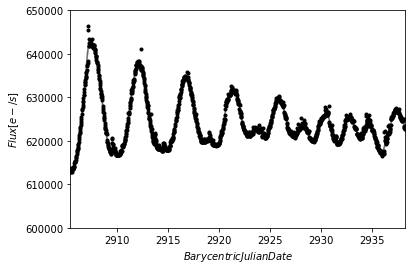

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[612618.92896776 612804.18461942 612963.92554427 ... 623070.71722133
 622716.37750877 622305.10046596]


In [51]:
lhs = min(pre.TIME)
rhs = max(pre.TIME)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
eobs = np.array(pre["PDCSAP_FLUX_ERR"])
print(yobs)
print(eobs)
print(np.abs(eobs/yobs))

kernel = np.var(yobs) * ExpSquaredKernel(0.5) # kernel number two
gp = george.GP(kernel)
gp.compute(xobs, eobs)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(yobs, xobs, return_var=True)

pl.fill_between(xobs, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(xobs, yobs, yerr=eobs, fmt=".k", capsize=0)
pl.xlim(lhs, rhs)
#pl.xlim(lhs,2910)
pl.ylim(600000,650000)
pl.xlabel(r'$Barycentric Julian Date$')
pl.ylabel(r'$Flux [e-/s]$')
pl.scatter(xobs, yobs, s=5)
pl.show()

print(yobs)
print(pred)

In [52]:
print(kernel)
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(yobs)))

ConstantKernel(log_constant=17.361727572324508, ndim=1, axes=array([0])) * ExpSquaredKernel(metric=Metric(0.5, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
Initial ln-likelihood: -783010.41


In [53]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(yobs)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(yobs)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(yobs)))

      fun: 22307.794742418635
 hess_inv: array([[ 0.00132274, -0.00298921],
       [-0.00298921,  0.00678036]])
      jac: array([-7.0434913e-06, -0.0000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([ 26.68931649, -22.40546688])

Final ln-likelihood: -22307.79


ConstantKernel(log_constant=26.68931649330111, ndim=1, axes=array([0])) * ExpSquaredKernel(metric=Metric(1.859642098754518e-10, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
[612915.24921465 612892.81171374 612824.81171301 ... 622910.74915956
 622810.18665949 622744.43665889]


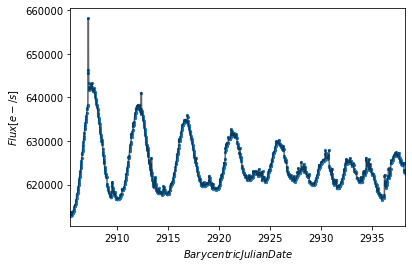

In [54]:
print(kernel)
pred, pred_var = gp.predict(yobs, xobs, return_var=True)
print(pred)
pl.fill_between(xobs, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
#pl.errorbar(xobs, yobs, yerr=yobs, fmt=".k", capsize=0)
pl.xlim(lhs, rhs)
#pl.xlim(lhs,2910)
#pl.ylim(600000,650000)
pl.xlabel(r'$Barycentric Julian Date$')
pl.ylabel(r'$Flux [e-/s]$')
pl.scatter(xobs, yobs, s=5)
pl.show()

Aaaaand I'm overfitting again. Note how the single parameter in the squared exponential kernel, the lengthscale (measure of smoothness), goes from a pretty smooth 0.5 to basically zero (decidedly not smooth). Moving forward, I'm going to stick with the non-maximized-likelihood model using the exponential squared kernel (probably the most basic kernel in Gaussian Processes) because it works (TM).

In [56]:
# resetting the kernel
kernel = np.var(yobs) * ExpSquaredKernel(0.5) # kernel number two
gp = george.GP(kernel)
gp.compute(xobs, eobs)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(yobs, xobs, return_var=True)

Let's get back to the rotation period later. For now, we can subtract out the inference from the data to get the flares.

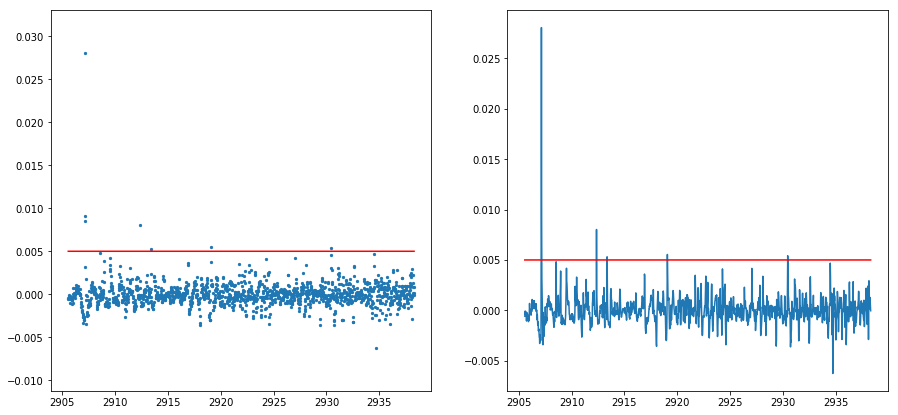

In [37]:
xobs_pre = np.array(pre["BJD - 2454833"])
yobs_pre = np.array(pre["Corrected Flux"])
eobs = 0.001*np.ones(len(pre)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5
threshold = 0.005

pl.subplot(121)
#x = np.linspace(2905.56,2984.26,70)
x_pre = np.linspace(pre['BJD - 2454833'][0], pre['BJD - 2454833'][len(pre)-1], 70)
m_pre,C_pre=Pred_GP(SEKernel,[A,Gamma],xobs_pre,yobs_pre,eobs,x_pre)
sig_pre = np.sqrt(np.diag(C_pre))
##pl.plot(pre['BJD - 2454833'],pre['Corrected Flux']-1)

#interpolate so I can subtract model from data
from scipy.interpolate import CubicSpline
cs_pre = CubicSpline(x_pre, m_pre)
###pl.plot(pre['BJD - 2454833'], cs(pre['BJD - 2454833'])-1)

pl.subplot(121)
pl.scatter(pre['BJD - 2454833'],pre['Corrected Flux']-cs_pre(pre['BJD - 2454833']),s=5)
pl.plot(xobs_pre,threshold*np.ones(len(xobs_pre)),c='r')
pl.subplot(122)
pl.plot(pre['BJD - 2454833'],pre['Corrected Flux']-cs_pre(pre['BJD - 2454833']))
pl.plot(xobs_pre,threshold*np.ones(len(xobs_pre)),c='r')

And the second half of the time series...

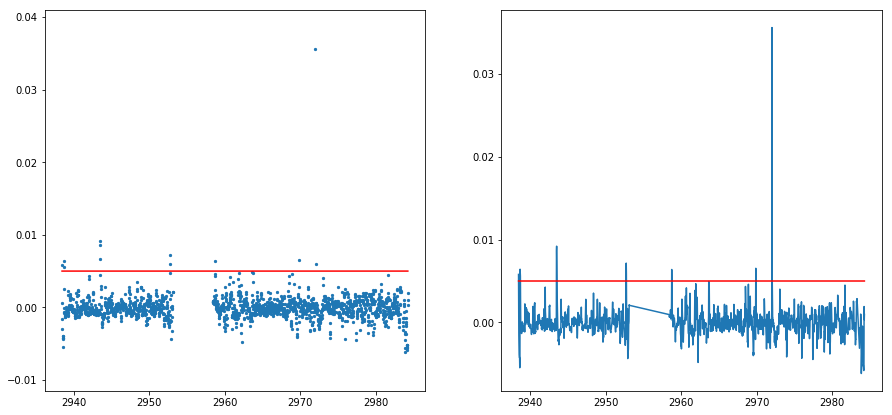

In [38]:
post = ts.iloc[1519:].reset_index()
xobs_post = np.array(post["BJD - 2454833"])
yobs_post = np.array(post["Corrected Flux"])
eobs = 0.001*np.ones(len(post)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5

# inference on post-super flare time series
pl.subplot(121)
x_post = np.linspace(post['BJD - 2454833'][0], post['BJD - 2454833'][len(post)-1], 70)
m_post,C_post=Pred_GP(SEKernel,[A,Gamma],xobs_post,yobs_post,eobs,x_post) 
sig_post = np.sqrt(np.diag(C_post))
###pl.plot(post['BJD - 2454833'],post['Corrected Flux']-1)

#interpolate so I can subtract model from data
from scipy.interpolate import CubicSpline
cs_post = CubicSpline(x_post, m_post)
###pl.plot(post['BJD - 2454833'], cs(post['BJD - 2454833'])-1)

pl.subplot(121)
pl.scatter(post['BJD - 2454833'],post['Corrected Flux']-cs_post(post['BJD - 2454833']),s=5)
threshold = 0.005
pl.plot(xobs_post,threshold*np.ones(len(xobs_post)),c='r')
pl.subplot(122)
pl.plot(post['BJD - 2454833'],post['Corrected Flux']-cs_post(post['BJD - 2454833']))
pl.plot(xobs_post,threshold*np.ones(len(xobs_post)),c='r')


Full timeseries - caution: fitting the whole thing causes the intensity around the super flare to be over-predicted. See further below.

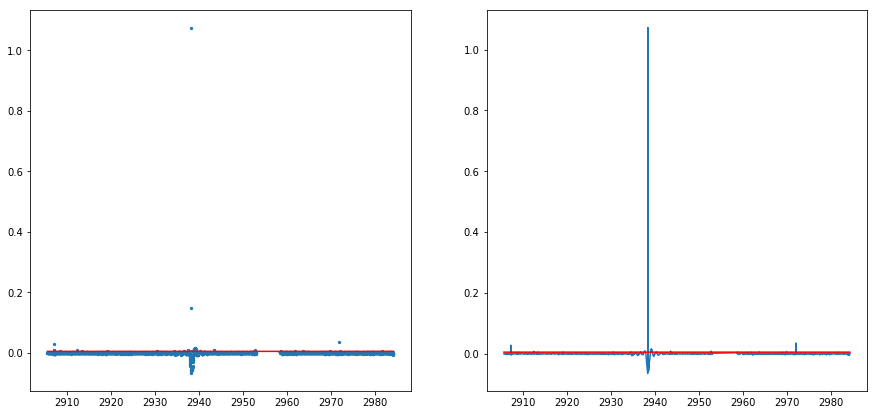

In [28]:
"""
xobs = np.array(ts["BJD - 2454833"])
yobs = np.array(ts["Corrected Flux"])
eobs = 0.001*np.ones(len(ts)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5
threshold = 0.005

pl.subplot(121)
x = np.linspace(ts['BJD - 2454833'][0], ts['BJD - 2454833'][len(ts)-1], 140)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))

#interpolate so I can subtract model from data
from scipy.interpolate import CubicSpline
cs = CubicSpline(x, m)

pl.subplot(121)
pl.scatter(ts['BJD - 2454833'],ts['Corrected Flux']-cs(ts['BJD - 2454833']),s=5)
threshold = 0.005
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')
#pl.ylim([-0.005,0.04])

pl.subplot(122)
pl.plot(ts['BJD - 2454833'],ts['Corrected Flux']-cs(ts['BJD - 2454833']))
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')
#pl.ylim([-0.005,0.04])

pl.show()
"""

**FLARES**

Using an actual peak finder to find flares' times, widths, and heights

**Pre chunk**

1514 5
[  71  311  358  627 1154]


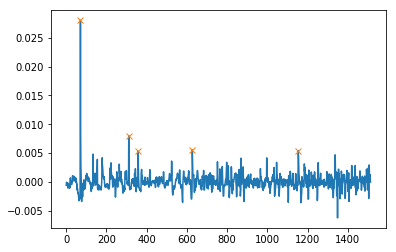

In [39]:
# pre chunk
from scipy.signal import find_peaks
from scipy.signal import peak_prominences

y = pre['Corrected Flux']-cs_pre(pre['BJD - 2454833'])
peaks, _ = find_peaks(y, height=0.005, distance=1) 
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()

In [13]:
print("Peaks: ")
print(y[peaks])
prominences, left_bases, right_bases = peak_prominences(y, peaks, wlen=8)
print("Prominences: ", prominences)
print("Left bases: ", left_bases)
print("Right bases: ", right_bases)
print("Widths: ", right_bases-left_bases)


Peaks: 
71      0.027864
311     0.007975
358     0.005284
627     0.005608
1154    0.005538
1337    0.006039
1437    0.006150
1477    0.006534
1480    0.007587
1484    0.009051
1486    0.005835
Name: Corrected Flux, dtype: float64
Prominences:  [2.84288215e-02 8.55169162e-03 6.10718110e-03 4.47046578e-03
 4.25133424e-03 4.10097787e-03 3.82551052e-03 3.12204774e-06
 4.61731707e-04 1.92605867e-03 4.92243625e-05]
Left bases:  [  68  308  357  623 1151 1333 1433 1473 1476 1483 1485]
Right bases:  [  75  315  362  631 1158 1340 1440 1478 1483 1488 1490]
Widths:  [7 7 5 8 7 7 7 5 7 5 5]


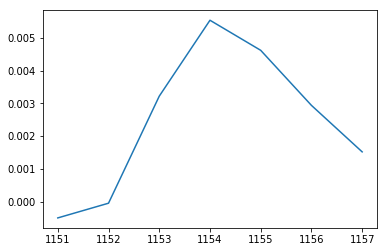

In [14]:
# flare width, for example comparison
pl.plot(y[1151:1158])
pl.show()

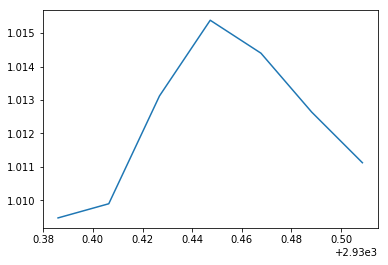

In [15]:
start = 1151
end = 1158
pl.plot(ts["BJD - 2454833"][start:end], ts["Corrected Flux"][start:end])
pl.show()

**Post chunk**

1834 6
[  10  226  652  686 1192 1291]


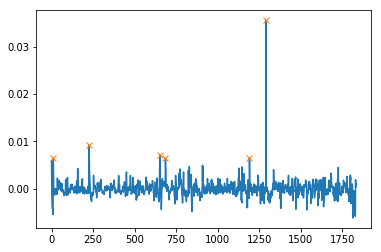

In [40]:
# post chunk
from scipy.signal import find_peaks
from scipy.signal import peak_prominences

y = post['Corrected Flux']-cs_post(post['BJD - 2454833'])
peaks, _ = find_peaks(y, height=0.005, distance=1) 
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()


In [17]:
print("Peaks: ")
print(y[peaks])
prominences, left_bases, right_bases = peak_prominences(y, peaks, wlen=4)
print("Prominences: ", prominences)
print("Left bases: ", left_bases)
print("Right bases: ", right_bases)
print("Widths: ", right_bases-left_bases)

Peaks: 
28      0.015902
35      0.011309
85      0.005329
226     0.008610
652     0.008268
686     0.005398
1192    0.006813
1291    0.035054
Name: Corrected Flux, dtype: float64
Prominences:  [0.0022522  0.00206233 0.00194902 0.00459454 0.00532601 0.00257945
 0.00560907 0.03470885]
Left bases:  [  26   34   83  224  650  684 1191 1289]
Right bases:  [  30   37   87  228  654  688 1194 1293]
Widths:  [4 3 4 4 4 4 3 4]


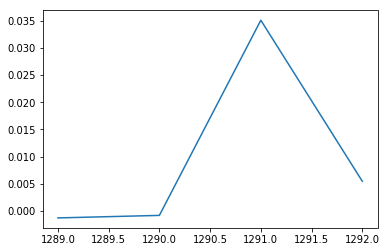

In [18]:
# flare width, for example comparison
pl.plot(y[1289:1293])
pl.show()

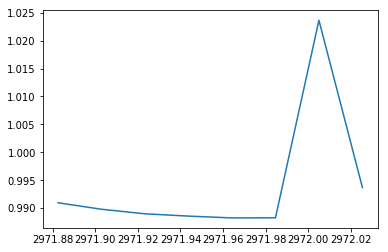

In [19]:
start = 1285 + 1519
end = 1293 + 1519
pl.plot(ts["BJD - 2454833"][start:end], ts["Corrected Flux"][start:end])
pl.show()

Evidently 30-minute cadence might not be granular enough to be the right tool for capturing flare duration.

**Double Plot for Figure 2**

In [ ]:
#fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(10, 5))

# left plot: pre
pl.subplot(121)
y = pre['Corrected Flux']-cs_pre(pre['BJD - 2454833'])
peaks, _ = find_peaks(y, height=0.005, distance=1) 
pl.plot(y)
pl.plot(peaks, y[peaks], "x")

# right plot: post
pl.subplot(122)
y = post['Corrected Flux']-cs_post(post['BJD - 2454833'])
peaks, _ = find_peaks(y, height=0.005, distance=1) 
pl.plot(y)
pl.plot(peaks, y[peaks], "x")


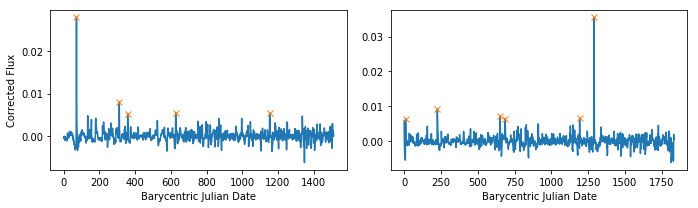

In [67]:
f = pl.figure(figsize=(10,3))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
y = pre['Corrected Flux']-cs_pre(pre['BJD - 2454833'])
peaks, _ = find_peaks(y, height=0.005, distance=1)
ax1.set(xlabel='Barycentric Julian Date', ylabel='Corrected Flux')
ax1.plot(y)
ax1.plot(peaks, y[peaks], "x")

y = post['Corrected Flux']-cs_post(post['BJD - 2454833'])
peaks, _ = find_peaks(y, height=0.005, distance=1) 
ax2.set(xlabel='Barycentric Julian Date')
ax2.plot(y)
ax2.plot(peaks, y[peaks], "x")

f.tight_layout() # fixes cutting off of x-axis labels

#pl.savefig("fig2.pdf")

**Full timeseries**

For completeness's sake. See caution above on over-predicting near the superflare, which is probably why flares here are a bit different than in corresponding chunks.

3353 12
[  71  311  627 1154 1337 1437 1515 1604 1745 2171 2711 2810]


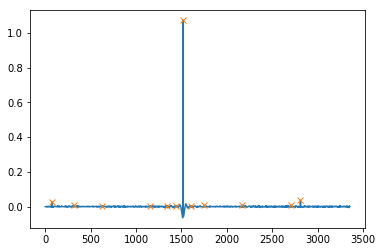

In [255]:
y = ts['Corrected Flux']-cs(ts['BJD - 2454833'])
peaks, _ = find_peaks(y, height=0.005, distance=48) # ignore smaller peaks within 24 hours of peak
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()

In [256]:
print("Peaks: ")
print(y[peaks])
prominences, left_bases, right_bases = peak_prominences(y, peaks, wlen=4)
print("Prominences: ", prominences)
print("Left bases: ", left_bases)
print("Right bases: ", right_bases)
print("Widths: ", right_bases-left_bases)

Peaks: 
71      0.027864
311     0.007975
627     0.005608
1154    0.005538
1337    0.006039
1437    0.006150
1515    1.072436
1604    0.005329
1745    0.008610
2171    0.008268
2711    0.006813
2810    0.035054
Name: Corrected Flux, dtype: float64
Prominences:  [0.02500672 0.00734641 0.00378779 0.00259818 0.00401452 0.00193486
 1.06477373 0.00194902 0.00459454 0.00532601 0.00560907 0.03470885]
Left bases:  [  69  309  625 1152 1335 1435 1513 1602 1743 2169 2710 2808]
Right bases:  [  73  313  629 1156 1339 1438 1517 1606 1747 2173 2713 2812]
Widths:  [4 4 4 4 4 3 4 4 4 4 3 4]


**PERIOD AND AMPLITUDE CHANGE**

First retrieve peaks of the curve fitted to the data

**Pre**

1514 11
[  85  299  517  742  849  942 1054 1149 1261 1349 1473]


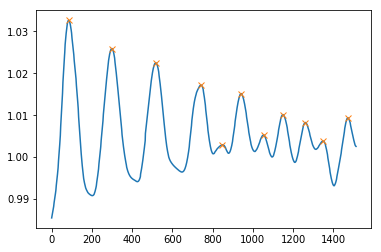

[214 218 225 107  93 112  95 112  88 124]


In [68]:
# run peak finder on the GP-produced curve only...with more liberal threshold
y = cs_pre(pre['BJD - 2454833'])
peaks, _ = find_peaks(y, distance=1) # or 50 hours
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()

print(np.diff(peaks))

1514 8
[  85  299  517  742  942 1149 1261 1473]


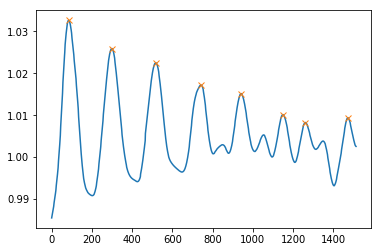

[214 218 225 200 207 112 212]


In [69]:
# run peak finder on the GP-produced curve only...with more conservative threshold
y = cs_pre(pre['BJD - 2454833'])
peaks, _ = find_peaks(y, distance=100) # or 50 hours
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()

print(np.diff(peaks))

From both of these and the raw data below, it's tough to tell what's really going on in terms of peak spacing during the days leading up to the super flare.

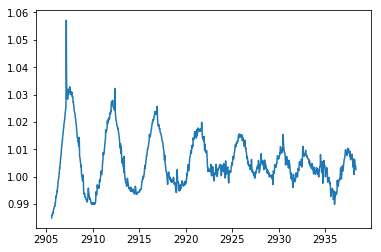

In [312]:
pl.plot(pre['BJD - 2454833'], pre['Corrected Flux'])
pl.show()

In [288]:
# peak stats for more conservative peak threshold
print("Peaks: ")
print(y[peaks])
prominences, left_bases, right_bases = peak_prominences(y, peaks, wlen=250)
print("Prominences: ", prominences)
print("Left bases: ", left_bases)
print("Right bases: ", right_bases)
print("Widths: ", right_bases-left_bases)

Peaks: 
[1.03268615 1.02593674 1.02251769 1.01721967 1.01516693 1.01016331
 1.00827354 1.00941936]
Prominences:  [0.04187435 0.03177323 0.02601101 0.01642034 0.01381362 0.01011971
 0.00951856 0.00685024]
Left bases:  [   0  202  426  647  880 1096 1209 1404]
Right bases:  [ 202  424  642  803 1010 1209 1386 1513]
Widths:  [202 222 216 156 130 113 177 109]


Peak widths seem pretty uniform until closer to the super flare when they get skinnier.

Amplitude also seems to decay linearly (possibly logarithmically?). Next to do will be to fit some models.

In [386]:
### MODELS...pre fitting, just for plotting

# proxy for linear model to calibrate curve_fit params
def linear_test(x):
    return -0.0003*x + 1.035

# proxy for sqrt model to calibrate initial conditions and test curve_fit's params
def sqrt_test(x):
    return 1.*np.sqrt(1-0.9*x**2)+1.035

# proxy for log model to calibrate initial conditions and test curve_fit's params
def log_test(x):
    return -0.004*np.log(1.*x) + 1.035

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


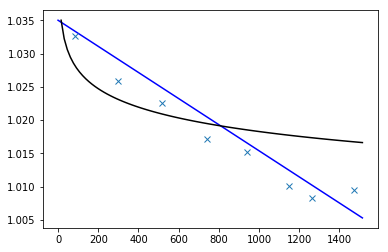

In [387]:
### PLOTTING
y_sqrt_test = []
y_linear_test = []
y_log_test = []

x = np.linspace(0,len(pre),100)
for i in range(100):
    y_sqrt_test.append(sqrt_test(i))
    y_linear_test.append(linear_test(i))
    y_log_test.append(log_test(i))
    
pl.plot(x,y_linear_test,color='b')
#pl.plot(x,y_sqrt_test,color='g')
pl.plot(x,y_log_test,color='k')
pl.plot(peaks, y[peaks], "x")
pl.show()


Some real fits are needed.

**Post**

1834 9
[ 165  379  597  768  979 1188 1395 1609 1804]


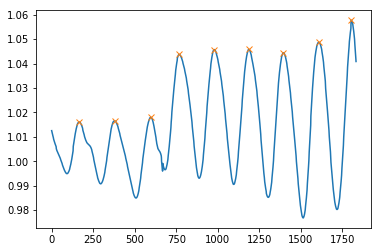

[214 218 171 211 209 207 214 195]


In [331]:
# run peak finder on the GP-produced curve only...with more liberal threshold
y = cs(post['BJD - 2454833'])
peaks, _ = find_peaks(y, distance=100) # or 50 hours
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()

print(np.diff(peaks))

Interesting that the second biggest flare after the super flare in this time series happens to be during the only significantly deviant gap (85.5 hours rather than 100+ hours)

In [332]:
# peak stats
print("Peaks: ")
print(y[peaks])
prominences, left_bases, right_bases = peak_prominences(y, peaks, wlen=250)
print("Prominences: ", prominences)
print("Left bases: ", left_bases)
print("Right bases: ", right_bases)
print("Widths: ", right_bases-left_bases)

Peaks: 
[1.01606613 1.01653192 1.01797359 1.04373986 1.04569511 1.04578587
 1.04437873 1.04870841 1.05771267]
Prominences:  [0.02115859 0.02578867 0.02201905 0.04778532 0.05267169 0.05528119
 0.05917075 0.06847126 0.01689348]
Left bases:  [  92  296  508  668  889 1096 1304 1515 1718]
Right bases:  [ 290  504  668  889 1096 1304 1515 1718 1833]
Widths:  [198 208 160 221 207 208 211 203 115]


And same with widths. Is the flare somehow responsible for the early 'exit' from its current period?

Amplitudes here don't seem to follow anything other than a flat step function (before secondary flare and after secondary flare), but the last couple periods suggest a ramping up of amplitude...although with only three points, it's tough to say anything else about it.

**Double Plot for Figure 3**

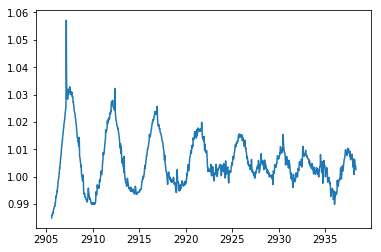

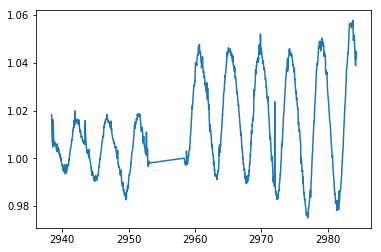

In [70]:
pl.plot(pre['BJD - 2454833'], pre['Corrected Flux'])
pl.show()

pl.plot(post['BJD - 2454833'], post['Corrected Flux'])
pl.show()

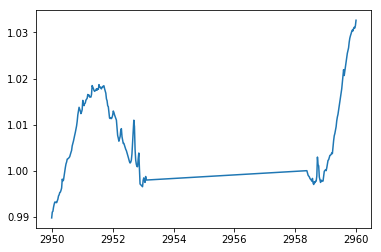

In [79]:
gap = ts.loc[(ts['BJD - 2454833'] > 2950) & (ts['BJD - 2454833'] < 2960)]
pl.plot(gap['BJD - 2454833'], gap['Corrected Flux'])
pl.show()

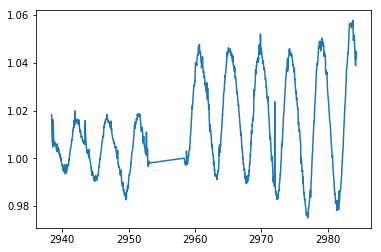

In [80]:
pl.plot(post['BJD - 2454833'], post['Corrected Flux'])
pl.show()

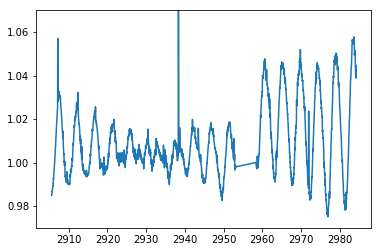

In [85]:
pl.plot(ts['BJD - 2454833'], ts['Corrected Flux'])
pl.ylim([0.97, 1.07])
pl.show()